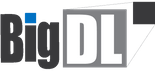

# Introduction
In this notebook we demonstrates how to use Nano HPO to search the learning rate in tensorflow training.

# Step0: Prepare Environment
You can install the latest pre-release version with nano support using below commands.

We recommend to run below commands, especially `source bigdl-nano-init` before jupyter kernel is started, or some of the optimizations may not take effect.

In [ ]:
# Install latest pre-release version of bigdl-nano
!pip install --pre bigdl-nano[tensorflow]
!pip install setuptools==58.0.4
!pip install protobuf==3.20.1
!source bigdl-nano-init

In [ ]:
# Install other dependecies for Nano HPO
!pip install ConfigSpace
!pip install optuna

# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [ ]:
import bigdl.nano.automl as automl
import bigdl.nano.automl.hpo as hpo
automl.hpo_config.enable_hpo_tf()

# Step2: Prepare data
We use fashion MNIST dataset for demonstration.

In [ ]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

CLASSES = 10

img_x, img_y = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

# Step3: Build model
We now create our model. 

Decorate the model class with hpo.tfmodel, and you will be able to specify search spaces in init arguments when creating the model, as shown below. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).


In [ ]:
from bigdl.nano.automl.tf.keras import Sequential
from bigdl.nano.tf.keras.layers import Dense, Flatten, Conv2D

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(CLASSES, activation="softmax"))

# Step4: Search the Learning Rate
To search the learning rate, specify search space in learning_rate argument in the optimizer argument in model.compile. Remember to import the optimizer from bigdl.nano.tf.optimizers instead of tf.keras.optimizers.

In [ ]:
import bigdl.nano.automl.hpo.space as space
from bigdl.nano.tf.optimizers import RMSprop
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=RMSprop(learning_rate=space.Real(0.0001, 0.01, log=True)),
    metrics=["accuracy"],
)

In [ ]:
model.search(n_trials=5, target_metric='accuracy', direction="maximize",
    x=x_train, y=y_train, batch_size=32, epochs=5, validation_split=0.2)

In [ ]:
study = model.search_summary()
study.trials_dataframe(attrs=("number", "value", "params", "state"))